In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import sklearn.utils
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
from PIL import Image

%matplotlib inline

/Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Volumes/Data/ethan/.env_tf110_p36/lib/python3

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
x, y = mnist.train.next_batch(2500)
x, y = sklearn.utils.shuffle(x, y, random_state=0)
x = x.reshape((x.shape[0], 28, 28, 1))

W0804 16:01:42.012549 4669572544 deprecation.py:323] From <ipython-input-2-5f4a4e475351>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0804 16:01:42.013880 4669572544 deprecation.py:323] From /Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0804 16:01:42.015141 4669572544 deprecation.py:323] From /Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0804 16:01:42.233819 4669572544 deprecation.py:323] From /Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
cats = np.argmax(y, axis=1)
classes = np.unique(cats)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


## Compare the distribution of training set and test set

In [4]:
x_test, y_test = mnist.test.next_batch(1000)

def compute_dist(y):
    cats = np.argmax(y, axis=1)
    c = np.bincount(cats)
    return c / np.sum(c)
    
train_dist = compute_dist(y)
test_dist = compute_dist(y_test)

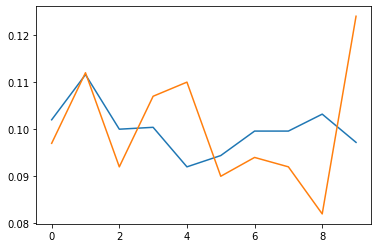

In [5]:
# Compare the two distributions
fig = plt.figure()
ax = plt.axes()

_x = np.arange(0, len(classes))
ax.plot(_x, train_dist)
ax.plot(_x, test_dist)

It seems like there are differences between training set and test set. The data is quite imbalanced.

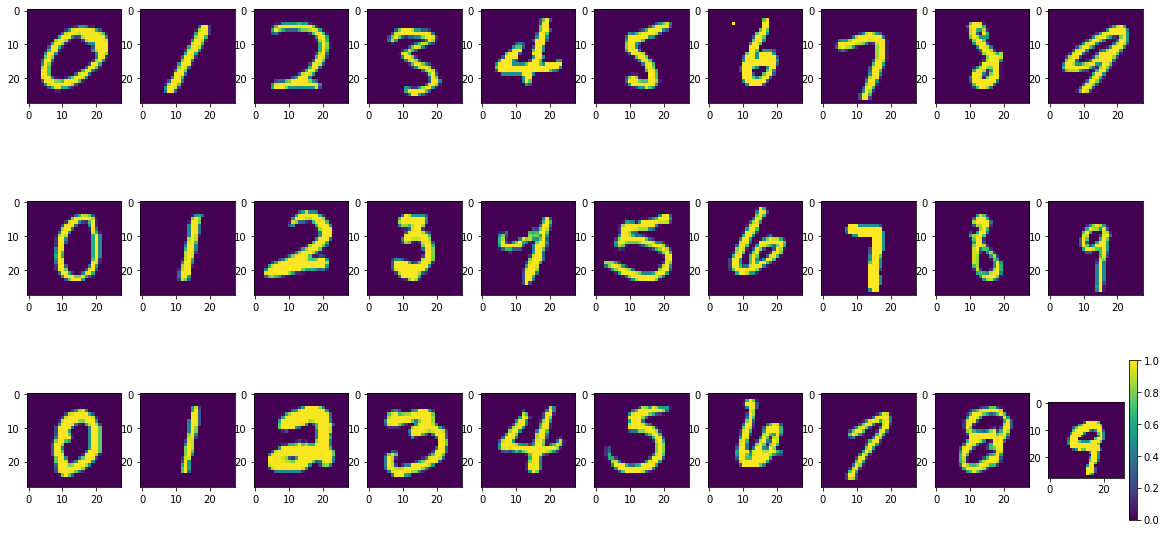

In [6]:
# View images form all classes
fig, axes = plt.subplots(3, len(classes))
fig.set_size_inches(20, 10)
for i, cl in enumerate(classes):
    class_indices = np.where(cats == cl)[0]
    for j in range(3):
        img_index = random.sample(list(class_indices), 1)
        img = x[img_index, :, :, 0].squeeze()
        p = axes[j][i].imshow(img)
fig.colorbar(p)

Check the histogram of the dataset

(array([1599701.,   15124.,   11866.,   11058.,    9947.,   10195.,
           8655.,    8551.,    8377.,    8056.,    8293.,   11071.,
           8281.,    9122.,    8760.,    8784.,   11099.,    9500.,
          11261.,   12393.,   16247.,  153659.]),
 array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181819,
        0.22727273, 0.27272728, 0.3181818 , 0.36363637, 0.4090909 ,
        0.45454547, 0.5       , 0.54545456, 0.59090906, 0.6363636 ,
        0.6818182 , 0.72727275, 0.77272725, 0.8181818 , 0.8636364 ,
        0.90909094, 0.95454544, 1.        ], dtype=float32),
 <a list of 22 Patch objects>)

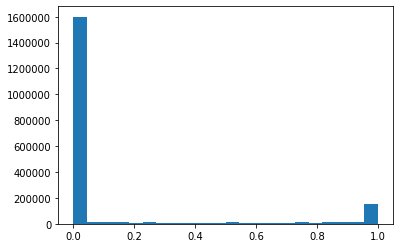

In [7]:
plt.hist(x.ravel(), bins='auto')

Most of the pixels are black, very few of them are grey. We can probaly convert the images to binary images without lossing much information.

Now compute the mean images for each classes.

Text(0.5, 0.98, 'Centroids')

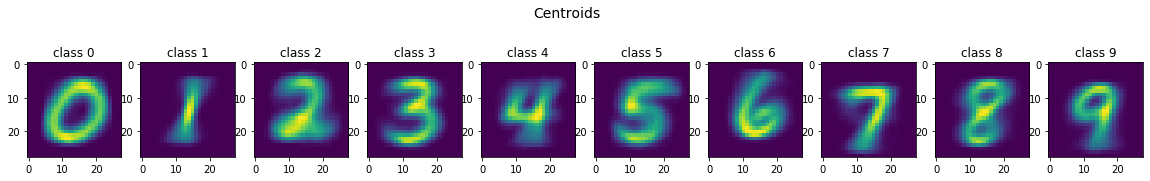

In [8]:
mean_images = []
fig, axes = plt.subplots(1, len(classes))
fig.set_size_inches(20, 3)
for i, cl in enumerate(classes):
    class_imgs = x[cats == cl, :, :, 0]
    mean_image = np.mean(class_imgs, axis = 0, keepdims=False)
    mean_images.append(mean_image)
    axes[i].imshow(mean_image)
    axes[i].set_title('class' + ' ' + str(cl))

fig.suptitle("Centroids", fontsize=14)

## Atypical instances

Measure variability within each classes using euclidean distance

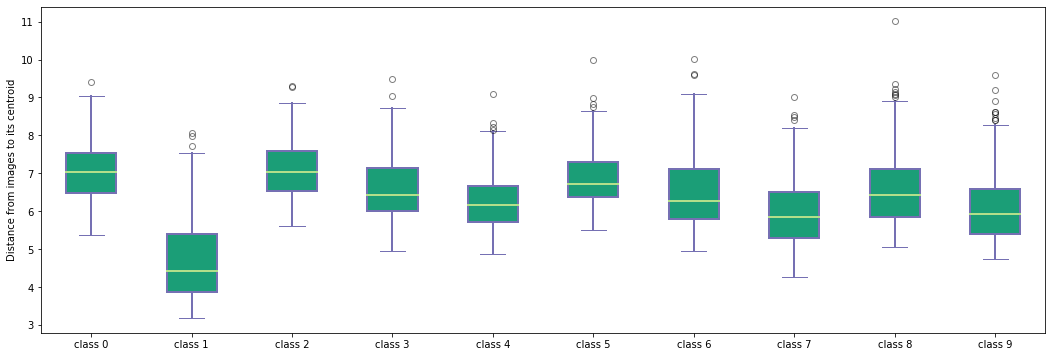

In [9]:
distances = []
for i, cl in enumerate(classes):
    class_imgs = x[cats == cl, :, :, 0]
    sts = class_imgs - mean_images[i]
    sts_square = sts**2
    dts = np.sqrt(np.sum(np.sum(sts_square, axis =-1, keepdims=False), axis =-1, keepdims=False))
    distances.append(dts)

fig = plt.figure(1, figsize=(18, 6))
ax = fig.add_subplot(111)

## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(distances, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=1)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

## Custom x-axis labels
ax.set_xticklabels(['class ' + str(c) for c in classes])

plt.ylabel('Distance from images to its centroid')
print()

So 1's have the least distance to the centroid and every classes have some cases that have unusually large distance to the centroid. Let's check them out.

Text(0.5, 0.98, 'Least typical images')

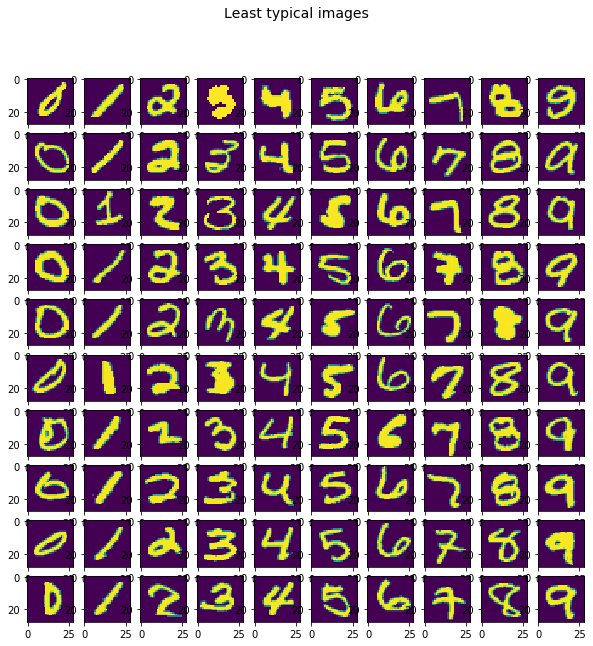

In [10]:
fig, axes = plt.subplots(10, len(classes))
fig.set_size_inches(10, 10)
for i, dts in enumerate(distances):
    class_imgs = x[cats == classes[i], :, :, 0]
    
    # get top 10 distance in each classes
    top_10 = dts.argsort()[-10:][::-1]
    for j, idx in enumerate(top_10):
        img = class_imgs[idx, :, :].squeeze()
        axes[j][i].imshow(img)
        
fig.suptitle("Least typical images", fontsize=14)

## Pairwise comparisons of digits

Lets see how hard to distinguish those images. To examine this, we could try overlapping pairs of our centroid digits, and taking the difference between them. If two centroids have very little overlap, this means they’ll probably be easy to distinguish.

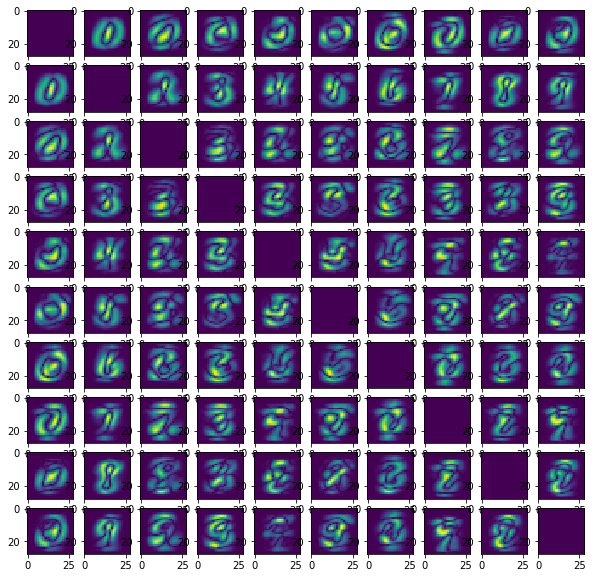

In [11]:
fig, axes = plt.subplots(len(classes), len(classes))
fig.set_size_inches(len(classes), len(classes))
for i, cl in enumerate(classes):
    mean_img = mean_images[i]
    for j, cl_ in enumerate(classes):
        mean_img_ = mean_images[j]
        sbt_imgs = np.abs(mean_img - mean_img_)
        axes[i][j].imshow(sbt_imgs)

## Visualize the dataset with t-SNE

t-SNE is a good way to visualize the dataset to see how well it is clustered

In [12]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

plt_style = 'seaborn-talk'

In [13]:
def do_plot(X_fit, title=None, labels=cats):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col,
                           alpha=0.4)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col,
                           alpha=0.4)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

### 2D t-SNE

W0804 16:02:31.866241 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 16:02:31.872117 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 16:02:31.877943 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 1

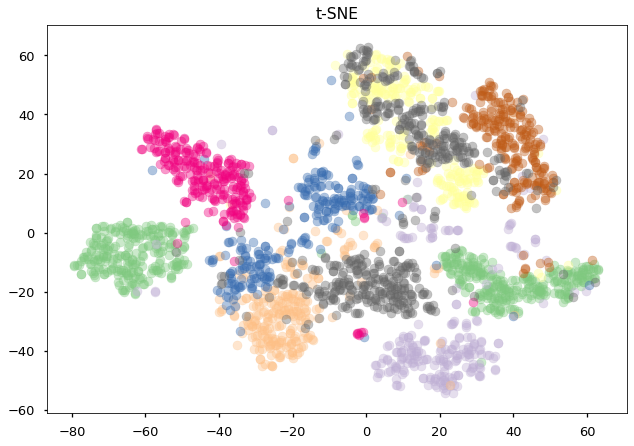

In [14]:
tsne2 = TSNE(n_components=2, random_state=0)
x_ = x.reshape((x.shape[0], -1))
do_plot(tsne2.fit_transform(x_), 't-SNE')

### 3D t-SNE

W0804 16:03:39.200147 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 16:03:39.206295 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 16:03:39.213033 4669572544 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0804 1

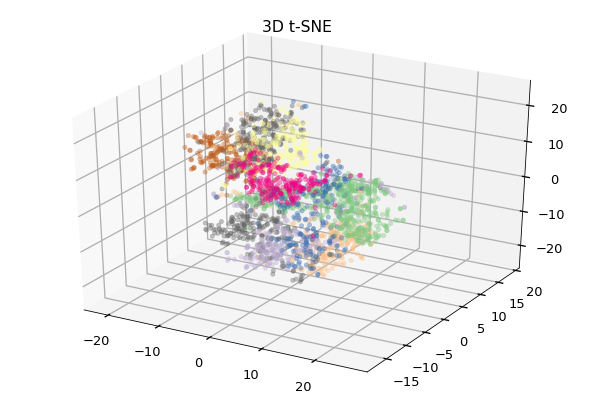

In [15]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
x_ = x.reshape((x.shape[0], -1))
do_plot(tsne3.fit_transform(x_), '3D t-SNE')

### Try t-SNE with plotly

In [16]:
!pip install plotly

In [25]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)

In [19]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
x_ = x.reshape((x.shape[0], -1))
sne_fit = tsne3.fit_transform(x_)

In [29]:
!pip install colorlover 

In [36]:
import colorlover as cl

def convert_colorscale_format(colorscale):
    plotly_colorscale = []
    for index, sec_value in enumerate(np.linspace(0, 1, len(colorscale))):
        plotly_colorscale.append([sec_value, colorscale[index]])
    return plotly_colorscale

colorset = cl.scales['10']['qual']['Set3']

cats = np.argmax(y, axis=1)
p1 = go.Scatter3d(x=sne_fit[:, 0], y=sne_fit[:, 1], z=sne_fit[:, 2],
                  mode='markers', 
                  marker=dict(color=cats,
                              colorscale=convert_colorscale_format(colorset),
                              showscale=False,
                              line=dict(color='black', width=1)),
                 text=cats)
layout=dict(
    title = 't-SNE',
    margin=dict(l=10, r=10,
                        t=30, b=10)
           )
fig = go.Figure(data=[p1], layout=layout)

py.offline.iplot(fig)

In [47]:
# Try Plotly with multiple traces

layout=dict(
    title = 't-SNE',
    margin=dict(l=10, r=10,
                        t=30, b=10)
           )

def update_plot(classes):
    data = []
    for i, cl in enumerate(classes):
        cl_x = sne_fit[cats == cl, :]
        trace = go.Scatter3d(x=cl_x[:, 0], y=cl_x[:, 1], z=cl_x[:, 2],
                      mode='markers', 
                      marker=dict(
                                  colorscale=convert_colorscale_format(colorset),
                                  showscale=False,
                                  line=dict(color='black', width=1)),
                     name='class {}'.format(cl),
                     text=[cl] * len(cl_x))
        data.append(trace)

    fig = go.Figure(data=data, layout=layout)

    py.offline.iplot(fig)
    
class_list = widgets.SelectMultiple(options=classes, value=(0,1, 2, 3, 4, 5, 6, 7, 8, 9), description='Class')

widgets.interactive(update_plot, classes=class_list)

interactive(children=(SelectMultiple(description='Class', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=(0, 1,…